In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/SSD/Code/TinyMPC/julia/quadrotor_quat/Project.toml`


In [2]:
using LinearAlgebra
using BlockDiagonals
using ForwardDiff
using Plots
using Random; 
using JuMP
using COSMO
using OSQP
using Printf

In [3]:
#Quaternion stuff
function hat(v)
    return [0 -v[3] v[2];
            v[3] 0 -v[1];
            -v[2] v[1] 0]
end
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s    -v';
         v  s*I+hat(v)]
    return L
end
T = Diagonal([1; -ones(3)])
H = [zeros(1,3); I]
function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end
function G(q)
    G = L(q)*H
end
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end
function qtorp(q)
    q[2:4]/q[1]
end
function E(q)
    E = BlockDiagonal([1.0*I(3), G(q), 1.0*I(6)])
end

function quad_dynamics(x,u)
    r = x[1:3]
    q = x[4:7]/norm(x[4:7]) #normalize q just to be careful
    v = x[8:10]
    ω = x[11:13]
    Q = qtoQ(q)
    
    ṙ = Q*v
    q̇ = 0.5*L(q)*H*ω
    
    v̇ = Q'*[0; 0; -g] + (1/m)*[zeros(2,4); kt*ones(1,4)]*u - hat(ω)*v
    
    ω̇ = J\(-hat(ω)*J*ω + [0 ℓ*kt 0 -ℓ*kt; -ℓ*kt 0 ℓ*kt 0; km -km km -km]*u)
    
    return [ṙ; q̇; v̇; ω̇]
end
function quad_dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5*h*f1, u)
    f3 = quad_dynamics(x + 0.5*h*f2, u)
    f4 = quad_dynamics(x + h*f3, u)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    xn[4:7] .= xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
    return xn
end

quad_dynamics_rk4 (generic function with 1 method)

In [4]:
#Quadrotor parameters
m = 0.027
ℓ = 0.046
J = [16.6e-6 0.83e-6 0.72e-6;
    0.83e-6 16.6e-6 1.8e-6;
    0.72e-6 1.8e-6 29.3e-6];
g = 9.81
kt = 1.0 #1.8221e-6
km = 0.005964552 #4.4733e-8

h = 1/50 #50 Hz

Nx = 13     # number of states (quaternion)
Nx̃ = 12     # number of states (linearized)
Nu = 4     # number of controls
Tfinal = 5.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
t_vec = h*(0:Nt-1)
thist = Array(range(0,h*(Nt-1), step=h));

# Cost weights
Q = Diagonal([10; 10; 10; 1; 1; 1; 1; 1; 1; 0.1; 0.1; 0.1]);
R = Array(I(Nu));

In [5]:
#Goal state
uhover = (m*g/4)*ones(4)
rg = [0.0; 0; 1.0]
qg = [1.0; 0; 0; 0]
vg = zeros(3)
ωg = zeros(3)
xg = [rg; qg; vg; ωg];

In [6]:
#Linearize dynamics about hover
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover),xg)
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(xg,u),uhover);
Ã = Array(E(qg)'*A*E(qg))
B̃ = Array(E(qg)'*B);
function discrete_dynamics(params,x,u,k)
  Ã*x + B̃*u
end

discrete_dynamics (generic function with 1 method)

In [7]:
#LQR Controller
# K = dlqr(Ã,B̃,Q,R)
#Feedback controller
function controller_lqr(x, k)
    
  q0 = x0[4:7]
  q = x[4:7]
  ϕ = qtorp(L(q0)'*q)
  
  Δx̃ = [x[1:3]-r0; ϕ; x[8:10]-v0; x[11:13]-ω0]
  
  u = uhover - K*Δx̃
end

controller_lqr (generic function with 1 method)

ΔJ = 0.030958389613857662
ΔJ = 6.314604769386278e-5
iter     J           ΔJ        |d|         α        reg         ρ
---------------------------------------------------------------------


  1    1.770e+02   6.31e-05   0.00e+00  1.0000    1.00e-08    1.00e+00
convio = 0.6784898694162754
ΔJ = 0.5333172394331598
ΔJ = 

0.046765378788251155
ΔJ = 0.0
  2    1.777e+02   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+01
convio = 0.43271488353338994
ΔJ = 0.1815934790294591


ΔJ = 2.5160138377887904
ΔJ = 0.3455796688047883
ΔJ = 0.0013257407933338072
  3    1.789e+02   1.33e-03   0.00e+00  1.0000    1.00e-08    1.00e+02
convio = 0.15134404509925306
ΔJ = 0.9393227143257832


ΔJ = 2.4484288028604055
ΔJ = 0.14529995697094478


ΔJ = 0.0
  4    1.803e+02   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+03
convio = 0.055474156666669744
ΔJ = 4.700989649146152
ΔJ = 0.0
  5    1.812e+02   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+04
convio = 0.008948113212688846
ΔJ = 1.313125729541639
ΔJ = 0.0
  6    1.814e+02   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+05
convio = 0.0009565237236547064
ΔJ = 

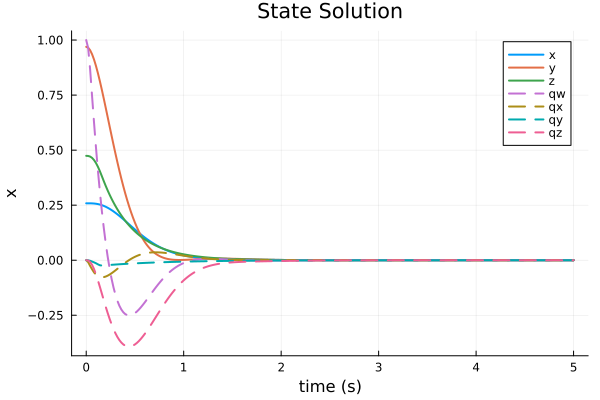

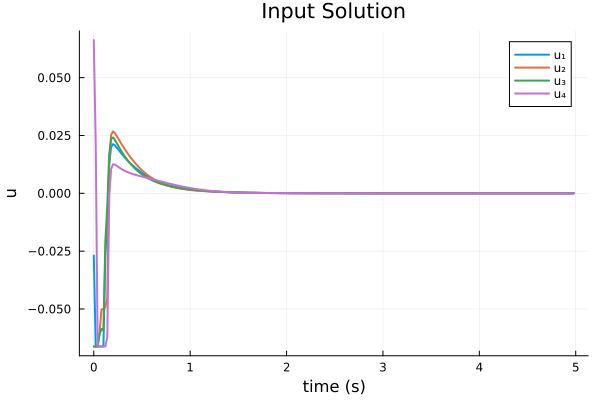

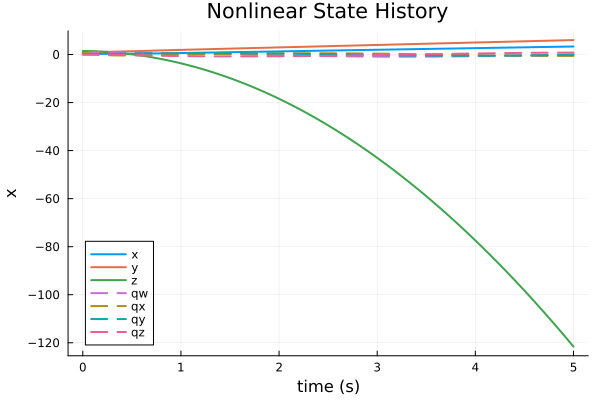

0.15154907744775414
ΔJ = 0.0
  7    1.814e+02   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+06
convio = 9.62945948362326e-5


In [8]:
#Feedback hovering controller
include("tinyMPC.jl")
nx = Nx̃
nu = Nu
N = Nt
dt = h

Δx̃g = zeros(nx)
Xref = [deepcopy(Δx̃g) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]

u_min = -1*uhover
u_max =  1*uhover

x_min = -100.0*ones(nx)
x_min[1:7] .= -.8
x_max = 100.0*ones(nx)
x_max[1:7] .= 1.0

max_inner_iters = 10  # MAX RICCATI SOLVING ITERATION
ncx = 2*nx*0
ncu = 2*nu*1
ncg = 1
ncu_cone = nu*0; 
cone_scale = 1e-3  # very fragile for each problem

μ = [zeros(ncu) for i = 1:N-1]   # input constraints
μx = [zeros(ncx) for i = 1:N]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint
A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(0)]

params = (
    nx = nx, nu = nu, ncx = ncx, ncu = ncu, ncg = ncg, ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone, c_cone = c_cone,
    N = N, Q = Q, R = R, Qf = 10*Q,
    u_min = u_min, u_max = u_max,
    x_min = x_min, x_max = x_max,
    Xref = Xref, Uref = Uref, dt = dt,
);

# previous MPC iterate
X = [zeros(nx) for i = 1:N]
U = [ones(nu) for k = 1:N-1]
# new MPC iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

Random.seed!(12);
x = [rg+rand(3); L(qg)*rptoq([1; 0; 0]); vg; ωg];
q = x[4:7]
ϕ = qtorp(L(qg)'*q)    
Δx̃ = [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
X[1] .= Δx̃
u = mpc!(params,X,U,P,p,K,d,Xn,Un; atol=1e-4,max_iters=20,verbose=true,ρ=1e0,ρ_max=1e10, ϕ=10.0)

# Open-loop Simulation
xhist = zeros(Nx,N)
xhist[:,1] = x
for k = 1:(N-1)
    xhist[:,k+1] = quad_dynamics_rk4(xhist[:,k],Un[k])
end

# Plots
Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
display(plot(t_vec,Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State Solution", xlabel="time (s)", ylabel="x"))
display(plot(t_vec[1:end-1],Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input Solution", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))
display(plot(t_vec,xhist[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="Nonlinear State History", xlabel="time (s)", ylabel="x"))             

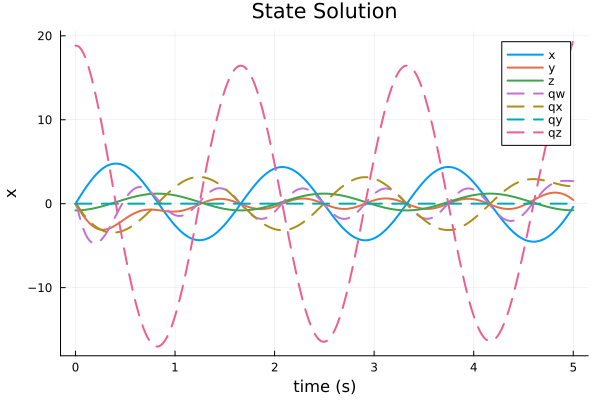

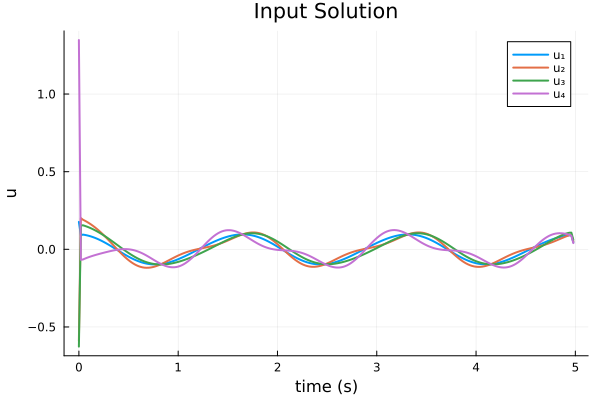

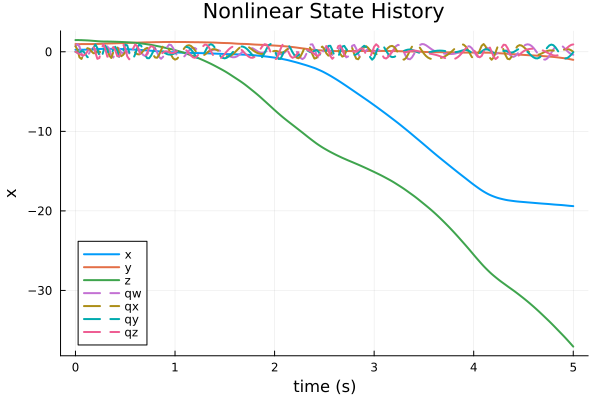

ΔJ = 0.0
iter     J           ΔJ        |d|         α        reg         ρ
---------------------------------------------------------------------
  1    2.670e+05   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+00
convio = 0


In [9]:
#Feedback tracking controller
include("tinyMPC.jl")
nx = Nx̃
nu = Nu
N = Nt
dt = h

# Δx̃g = zeros(nx)
# Xref = [deepcopy(Δx̃g) for i = 1:N]
Δx̃ref = [zeros(nx) for i = 1:Nt]
Uref = [zeros(nu) for i = 1:Nt-1]
Xref = [[5*cos(t);5*cos(t)*sin(t);1.2+sin(t);1;zeros(9)] for t = range(-pi/2, 3*pi/2 + 4*pi, length = Nt)]
for i = 1:Nt-1
    Xref[i][8:10] = (Xref[i+1][1:3] - Xref[i][1:3])/dt
end
for k = 1:Nt
    rref = Xref[k][1:3]
    qref = Xref[k][4:7]
    vref = Xref[k][8:10]
    ωref = Xref[k][11:13]
    ϕ = qtorp(L(qg)'*qref)    
    Δx̃ref[k] .= [-xg[1:3]+rref; ϕ; -xg[8:10]+vref; -xg[11:13]+ωref]
end
u_min = -uhover
u_max =  0.8*uhover

# state is x y v θ
x_min = -ones(nx)
x_max = ones(nx)

max_inner_iters = 10  # MAX RICCATI SOLVING ITERATION
ncx = 2*nx*0
ncu = 2*nu*0
ncg = 0
ncu_cone = nu*0; 
cone_scale = 1e-3  # very fragile for each problem

μ = [zeros(ncu) for i = 1:N-1]   # input constraints
μx = [zeros(ncx) for i = 1:N]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint
A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(0)]

params = (
    nx = nx, nu = nu, ncx = ncx, ncu = ncu, ncg = ncg, ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone, c_cone = c_cone,
    N = N, Q = 10*Q, R = R, Qf = 10*Q,
    u_min = u_min, u_max = u_max,
    x_min = x_min, x_max = x_max,
    Xref = Δx̃ref, Uref = Uref, dt = dt,
);

# previous MPC iterate
X = [zeros(nx) for i = 1:N]
U = [zeros(nu) for k = 1:N-1]
# new MPC iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

X[1] .= Δx̃ref[1]
u = mpc!(params,X,U,P,p,K,d,Xn,Un; atol=1e-4,max_iters=20,verbose=true,ρ=1e0,ρ_max=1e10, ϕ=10.0)

# Open-loop Simulation
xhist = zeros(Nx,N)
xhist[:,1] = x
for k = 1:(N-1)
    xhist[:,k+1] = quad_dynamics_rk4(xhist[:,k],Un[k])
end

# Plots
Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
display(plot(t_vec,Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State Solution", xlabel="time (s)", ylabel="x"))
display(plot(t_vec[1:end-1],Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input Solution", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))
display(plot(t_vec,xhist[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="Nonlinear State History", xlabel="time (s)", ylabel="x"))   

In [31]:
#Feedback tracking controller
include("tinyMPC.jl")
include("mpc_JuMP.jl")
nx = Nx̃
nu = Nu
N = 21
dt = h
Tfinal = 5.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
t_vec = h*(0:Nt-1)

#Create trajectory to follow
Xref = [[0;0;1;1;zeros(9)] for i = 1:Nt+N]
Δx̃ref = [zeros(nx) for i = 1:Nt+N]
Uref = [zeros(nu) for i = 1:Nt+N-1]

# Number-eight
Xref = [[5*cos(t);5*cos(t)*sin(t);1;1;zeros(9)] for t = range(0, 2*pi + pi/4, length = Nt+N)]  

# Triangle
p0 = [0; 0; 1.0]; p1 = [3; 2; 2.]; p2 = [6; 0; 2.]; p3 = [0; 0; 1.0]
range1 = collect(LinRange(p0, p1, round(Int,(Nt+N)/3)))
range2 = collect(LinRange(p1, p2, round(Int,(Nt+N)/3)))
range3 = collect(LinRange(p2, p3, round(Int,(Nt+N)/3)+1))
range123 = [range1; range2; range3]
for k = 1:Nt+N
    Xref[k][1:3] .= range123[k]
end

for i = 1:Nt+N-1
    Xref[i][8:10] = (Xref[i+1][1:3] - Xref[i][1:3])/dt
end
for k = 1:Nt+N
    x = Xref[k]
    q = x[4:7]
    ϕ = qtorp(L(qg)'*q)   
    Δx̃ref[k] .= [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
end

u_min = -0.7*uhover
u_max =  0.7*uhover

# state is x y v θ
x_min = -100*ones(nx)
x_min[3] = -0.3
x_max = 100*ones(nx)
x_max[3] = 0.3

max_inner_iters = 10  # MAX RICCATI SOLVING ITERATION
ncx = 2*nx*0
ncu = 2*nu*1
ncg = 0
ncu_cone = nu*0; 
cone_scale = 1e-3  # very fragile for each problem

μ = [zeros(ncu) for i = 1:N-1]   # input constraints
μx = [zeros(ncx) for i = 1:N]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint
A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(0)]

params = (
    nx = nx, nu = nu, ncx = ncx, ncu = ncu, ncg = ncg, ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone, c_cone = c_cone,
    N = N, Q = 10*Q, R = R, Qf = 10*Q,
    u_min = u_min, u_max = u_max,
    x_min = x_min, x_max = x_max,
    Xref = Δx̃ref, Uref = Uref, dt = dt,
);
# optimizer = JuMP.optimizer_with_attributes(COSMO.Optimizer,
#         "verbose"=>false,
#         "eps_abs"=>1e-4,
#         "eps_rel"=>1e-4,
#         "rho"=>1e-2,
#         "scaling"=>0,
#         "alpha"=>1.0)
optimizer = JuMP.optimizer_with_attributes(OSQP.Optimizer,
        "verbose"=>false,
        "eps_abs"=>1e-2,
        "eps_rel"=>1e-2,
        "eps_prim_inf"=>1e-2,
        "eps_dual_inf"=>1e-2)
        # "rho"=>1e-2,
        # "scaling"=>0,
        # "alpha"=>1.0,)        
# previous MPC iterate
X = [zeros(nx) for i = 1:N]
U = [zeros(nu) for k = 1:N-1]
# new MPC iterate
Xn = deepcopy(X)
Un = deepcopy(U)
    
P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

function controller_mpc(params, x, k)
    q = x[4:7]
    ϕ = qtorp(L(qg)'*q)
    
    Δx̃ = [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
    X[1] .= Δx̃
    u = mpc_JuMP(optimizer, params, X, U, Ã, B̃, 0.0; warm_start=true)
    # @time u = mpc!(params,X,U,P,p,K,d,Xn,Un; atol=1e-2,max_iters=10,verbose=false,ρ=1e0,ρ_max=1e6, ϕ=10.0)
    return u + uhover
end

controller_mpc (generic function with 1 method)

In [32]:
#Simulation
uhist = [zeros(Nu) for i in 1:Nt-1]
xhist = [zeros(Nx) for i in 1:Nt]
Random.seed!(12);
# xhist[1] .= [rg+randn(3); L(qg)*rptoq([1; 0; 0]); vg; ωg]  # initial conditions
xhist[1] .= Xref[1]
# xhist[1] .= Xref[1]; xhist[1][1:3] += rand(3)*1
for k = 1:(Nt-1)
    params1 = (; params..., Uref = Uref[k:N+k-1], Xref = Δx̃ref[k:N+k])  # update ref
    shift_fill(U)
    uhist[k] = controller_mpc(params1, xhist[k], k)
    uhist[k] = clamp.(uhist[k], (uhover+u_min)[1], (uhover+u_max)[1])
    xhist[k+1] = quad_dynamics_rk4(xhist[k],uhist[k]) 
end

  0.003861 seconds (10.55 k allocations: 1.508 MiB)
  0.003525 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003109 seconds (10.63 k allocations: 1.523 MiB)
  0.004678 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003343 seconds (10.63 k allocations: 1.523 MiB)
  0.002976 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003382 seconds (10.63 k allocations: 1.523 MiB)
  0.003024 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002919 seconds (10.63 k allocations: 1.523 MiB)
  0.003283 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002930 seconds (10.63 k allocations: 1.523 MiB)
  0.003280 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002994 seconds (10.63 k allocations: 1.523 MiB)
  0.003434 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002956 seconds (10.63 k allocations: 1.523 MiB)
  0.002889 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002949 seconds (10.63 k allocations: 1.523 MiB)
  0.003005 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003308 seconds (10.63 k allocations: 1.523 MiB)
  0.003013 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003349 seconds (10.63 k allocations: 1.523 MiB)
  0.004124 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002967 seconds (10.63 k allocations: 1.523 MiB)
  0.004363 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003162 seconds (10.63 k allocations: 1.523 MiB)
  0.003305 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002909 seconds (10.63 k allocations: 1.523 MiB)
  0.002763 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002889 seconds (10.63 k allocations: 1.523 MiB)
  0.003000 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003167 seconds (10.63 k allocations: 1.523 MiB)
  0.003007 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003098 seconds (10.63 k allocations: 1.523 MiB)
  0.002875 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002949 seconds (10.63 k allocations: 1.523 MiB)
  0.003241 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003048 seconds (10.63 k allocations: 1.523 MiB)
  0.004860 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003230 seconds (10.63 k allocations: 1.523 MiB)
  0.003003 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003180 seconds (10.63 k allocations: 1.523 MiB)
  0.002941 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003277 seconds (10.63 k allocations: 1.523 MiB)
  0.002886 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003159 seconds (10.63 k allocations: 1.523 MiB)
  0.003040 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003601 seconds (10.63 k allocations: 1.523 MiB)
  0.003242 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002983 seconds (10.63 k allocations: 1.523 MiB)
  0.003157 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003292 seconds (10.63 k allocations: 1.523 MiB)
  0.003064 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003089 seconds (10.63 k allocations: 1.523 MiB)
  0.002919 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.004054 seconds (10.63 k allocations: 1.523 MiB)
  0.003094 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.004106 seconds (10.63 k allocations: 1.523 MiB)
  0.003473 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003442 seconds (10.63 k allocations: 1.523 MiB)
  0.002865 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.004130 seconds (10.63 k allocations: 1.523 MiB)
  0.003626 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002890 seconds (10.63 k allocations: 1.523 MiB)
  0.003133 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003065 seconds (10.63 k allocations: 1.523 MiB)
  0.004200 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.004155 seconds (10.63 k allocations: 1.523 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.004280 seconds (10.63 k allocations: 1.518 MiB)
  0.004628 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003443 seconds (10.63 k allocations: 1.523 MiB)
  0.003239 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003715 seconds (10.63 k allocations: 1.522 MiB)
  0.002972 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002891 seconds (10.63 k allocations: 1.523 MiB)
  0.003242 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003231 seconds (10.63 k allocations: 1.522 MiB)
  0.002861 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003114 seconds (10.63 k allocations: 1.522 MiB)
  0.002849 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002932 seconds (10.63 k allocations: 1.522 MiB)
  0.003160 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ 

  0.002912 seconds (10.55 k allocations: 1.508 MiB)
  0.003443 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003022 seconds (10.55 k allocations: 1.508 MiB)
  0.003236 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002861 seconds (10.55 k allocations: 1.507 MiB)
  0.002818 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002931 seconds (10.63 k allocations: 1.518 MiB)
  0.002850 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003080 seconds (10.63 k allocations: 1.522 MiB)
  0.002991 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003849 seconds (10.63 k allocations: 1.522 MiB)
  0.002844 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002960 seconds (10.63 k allocations: 1.522 MiB)
  0.003364 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003920 seconds (10.63 k allocations: 1.522 MiB)
  0.002977 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002926 seconds (10.63 k allocations: 1.522 MiB)
  0.027431 seconds (10.55 k allocations: 1.507 MiB, 86.75% gc time)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003438 seconds (10.63 k allocations: 1.522 MiB)
  0.003277 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003692 seconds (10.63 k allocations: 1.522 MiB)
  0.003563 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.004922 seconds (10.63 k allocations: 1.522 MiB)
  0.004441 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003083 seconds (10.63 k allocations: 1.522 MiB)
  0.003254 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002888 seconds (10.63 k allocations: 1.522 MiB)
  0.003295 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003089 seconds (10.63 k allocations: 1.522 MiB)
  0.003000 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002925 seconds (10.63 k allocations: 1.522 MiB)
  0.003177 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003622 seconds (10.63 k allocations: 1.522 MiB)
  0.003002 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.004155 seconds (10.63 k allocations: 1.522 MiB)
  0.003870 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003618 seconds (10.63 k allocations: 1.522 MiB)
  0.003053 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003555 seconds (10.63 k allocations: 1.522 MiB)
  0.003233 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003284 seconds (10.63 k allocations: 1.522 MiB)
  0.003124 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003119 seconds (10.63 k allocations: 1.522 MiB)
  0.004205 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003486 seconds (10.63 k allocations: 1.522 MiB)
  0.003014 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003112 seconds (10.63 k allocations: 1.522 MiB)
  0.003191 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003573 seconds (10.63 k allocations: 1.522 MiB)
  0.002864 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003190 seconds (10.63 k allocations: 1.522 MiB)
  0.004034 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002914 seconds (10.63 k allocations: 1.522 MiB)
  0.003310 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003097 seconds (10.63 k allocations: 1.522 MiB)
  0.004686 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.004857 seconds (10.63 k allocations: 1.522 MiB)
  0.002923 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003257 seconds (10.63 k allocations: 1.522 MiB)
  0.004506 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.004203 seconds (10.63 k allocations: 1.522 MiB)
  0.002912 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003243 seconds (10.63 k allocations: 1.522 MiB)
  0.003346 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003058 seconds (10.63 k allocations: 1.522 MiB)
  0.004036 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003063 seconds (10.63 k allocations: 1.522 MiB)
  0.003027 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002946 seconds (10.63 k allocations: 1.522 MiB)
  0.002851 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003168 seconds (10.63 k allocations: 1.522 MiB)
  0.002925 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003541 seconds (10.63 k allocations: 1.522 MiB)
  0.002907 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003151 seconds (10.63 k allocations: 1.522 MiB)
  0.002906 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003314 seconds (10.63 k allocations: 1.522 MiB)
  0.003082 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002919 seconds (10.63 k allocations: 1.522 MiB)
  0.002956 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003020 seconds (10.63 k allocations: 1.522 MiB)
  0.004041 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003113 seconds (10.63 k allocations: 1.522 MiB)
  0.002966 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003183 seconds (10.63 k allocations: 1.522 MiB)
  0.002862 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003599 seconds (10.63 k allocations: 1.522 MiB)
  0.003147 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.004882 seconds (10.63 k allocations: 1.522 MiB)
  0.002972 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002920 seconds (10.63 k allocations: 1.522 MiB)
  0.003319 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002866 seconds (10.63 k allocations: 1.522 MiB)
  0.002851 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003382 seconds (10.63 k allocations: 1.521 MiB)
  0.003209 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003984 seconds (10.63 k allocations: 1.522 MiB)
  0.003184 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003208 seconds (10.63 k allocations: 1.521 MiB)
  0.002889 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003212 seconds (10.63 k allocations: 1.521 MiB)
  0.002830 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003024 seconds (10.63 k allocations: 1.521 MiB)
  0.003021 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003195 seconds (10.63 k allocations: 1.522 MiB)
  0.003101 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002935 seconds (10.63 k allocations: 1.521 MiB)
  0.003252 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002880 seconds (10.63 k allocations: 1.521 MiB)
  0.002969 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003016 seconds (10.63 k allocations: 1.521 MiB)
  0.003011 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003088 seconds (10.63 k allocations: 1.522 MiB)
  0.003359 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003914 seconds (10.63 k allocations: 1.521 MiB)
  0.002829 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002873 seconds (10.63 k allocations: 1.521 MiB)
  0.003286 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003106 seconds (10.63 k allocations: 1.521 MiB)
  0.004016 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.004622 seconds (10.63 k allocations: 1.522 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003887 seconds (10.63 k allocations: 1.517 MiB)
  0.003272 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003091 seconds (10.63 k allocations: 1.521 MiB)
  0.003246 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002992 seconds (10.63 k allocations: 1.521 MiB)
  0.003059 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002954 seconds (10.63 k allocations: 1.521 MiB)
  0.002821 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003163 seconds (10.63 k allocations: 1.521 MiB)
  0.002897 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.004137 seconds (10.63 k allocations: 1.521 MiB)
  0.002892 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003162 seconds (10.63 k allocations: 1.521 MiB)
  0.003072 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002903 seconds (10.63 k allocations: 1.521 MiB)
  0.003708 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.004538 seconds (10.63 k allocations: 1.521 MiB)
  0.004016 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003215 seconds (10.63 k allocations: 1.521 MiB)
  0.003391 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003132 seconds (10.63 k allocations: 1.521 MiB)
  0.003179 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.004267 seconds (10.63 k allocations: 1.521 MiB)
  0.002939 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003035 seconds (10.63 k allocations: 1.521 MiB)
  0.002996 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002843 seconds (10.63 k allocations: 1.521 MiB)
  0.003801 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003120 seconds (10.63 k allocations: 1.521 MiB)
  0.004366 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003485 seconds (10.63 k allocations: 1.521 MiB)
  0.003756 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003999 seconds (10.63 k allocations: 1.521 MiB)
  0.002851 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003270 seconds (10.63 k allocations: 1.521 MiB)
  0.003508 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003137 seconds (10.63 k allocations: 1.521 MiB)
  0.003099 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.004222 seconds (10.63 k allocations: 1.521 MiB)
  0.003334 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002913 seconds (10.63 k allocations: 1.521 MiB)
  0.003633 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002966 seconds (10.63 k allocations: 1.521 MiB)
  0.003131 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002898 seconds (10.63 k allocations: 1.521 MiB)
  0.003174 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003233 seconds (10.63 k allocations: 1.521 MiB)
  0.003043 seconds (10.55 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


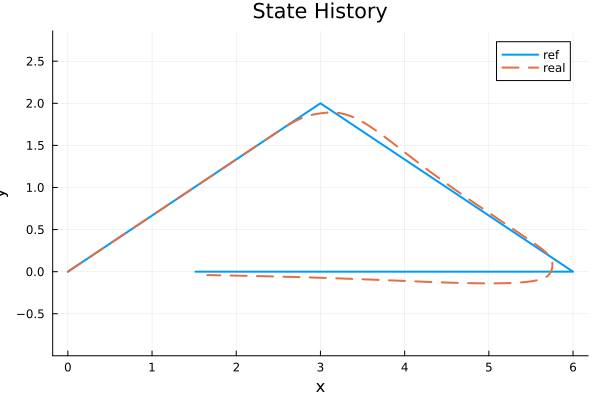

In [26]:
Xsim_m = mat_from_vec(Xref[1:Nt])
plot(Xsim_m[1,:],Xsim_m[2,:],label="ref",
linestyle=:solid, linewidth=2,
             title="State History", xlabel="x", ylabel="y")
Xsim_m = mat_from_vec(xhist[1:Nt])   
display(plot!(Xsim_m[1,:],Xsim_m[2,:],label="real", linestyle=:dash, linewidth=2,
             title="State History", xlabel="x", ylabel="y", aspect_ratio=:equal))

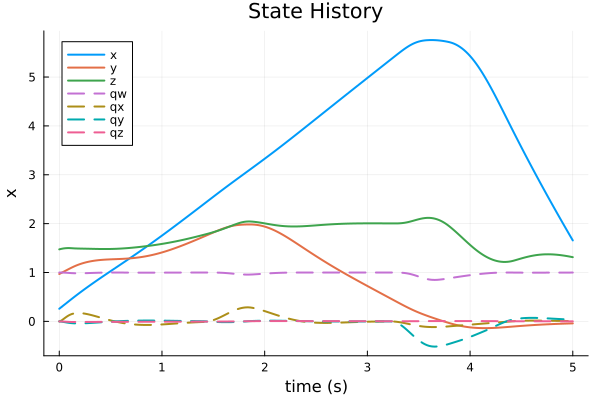

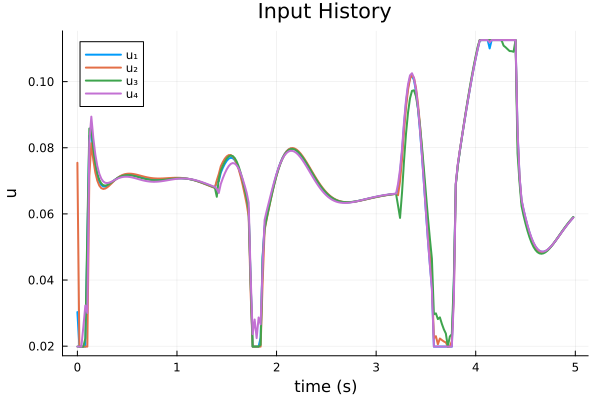

In [13]:
Xsim_m = mat_from_vec(xhist[1:Nt])   
Usim_m = mat_from_vec(uhist[1:Nt-1])   
display(plot(t_vec,Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State History", xlabel="time (s)", ylabel="x"))
display(plot(t_vec[1:end-1],Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input History", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))

In [14]:
#Set up visualization
using TrajOptPlots
using MeshCat
using StaticArrays
using RobotZoo:Quadrotor

vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/khai/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8700))

In [15]:
model = Quadrotor()
TrajOptPlots.set_mesh!(vis, model)

false

In [16]:
X1 = [SVector{13}(x) for x in xhist];
visualize!(vis, model, t_vec[end], X1)